## Problem Definition

In [7]:
import scipy
import numpy as np
import gym
from gym import spaces
import random

def optimal_lqr_control(A, B, Q, R):

    '''
    Solve the continuous-time LQR problem given A, B, Q, R.

    Parameters
    ----------
    A : numpy.ndarray
        The state matrix.
    B : numpy.ndarray
        The control matrix.
    Q : numpy.ndarray
        The state cost matrix.
    R : numpy.ndarray
        The control cost matrix.

    Returns
    -------
    K : numpy.ndarray
        The optimal LQR gain.
    '''
    # Solve the Riccati equation
    P = scipy.linalg.solve_continuous_are(A, B, Q, R)

    # Compute the LQR gain
    K = np.linalg.inv(R) @ B.T @ P

    return K

class CircleRotationEnv(gym.Env):

    def __init__(self,
                 s_init: np.array,
                 k_x=0,
                 k_y=0,
                 k_p=0,
                 q_x=1,
                 q_y=1,
                 q_r=0.2,
                 theta=0,
                 sigma_noise=0.0):
        
        self.k_x = k_x
        self.k_y = k_y
        self.k_p = k_p
        self.q_x = q_x
        self.q_y = q_y
        self.q_r = q_r
        self.theta = theta
        self.state_dim = 2
        self.action_dim = 2
        self.sigma_noise = sigma_noise
        self.observation_space = spaces.Box(low=-2.0, high=2.0, shape=(2,), dtype=np.float32)
        self.action_space = spaces.Box(low=-0.1, high=0.1, shape=(2,), dtype=np.float32)

        # Define system dynamics
        self.A = np.array([[-(k_x + k_p), 0.0],
                           [0.0, -(k_y + k_p)]])
        self.B_init = np.eye(2)
        self.B = self.B_init
    
        self.Q = np.array([[self.q_x, 0.0],
                      [0.0, self.q_y]])
        self.R = np.eye(2) * self.q_r

        self.s_0 = s_init
        self.s = self.s_0

        self.episode_length = 100
        self.step_count = 0
        self.step_width = 1
        self.goal_state = np.array([0,0], dtype=np.float32) #only used to check whether agent reached goal state.


    def reset(self):

        '''
        Reset the system to its initial state. Does not reset the rotation matrix.
        '''

        self.step_count = 0
        self.s = self.s_0.copy()
        return self.s
    

    def step(self, u):

        '''
        Step the system forward by one time step from state s with control input u. Returns the next state, the cost and whether the episode is done.
        '''


        self.s+= self.step_width*(self.A @ self.s + self.B @ u)
        self.s += np.random.normal(loc=0, scale=self.sigma_noise, size=2) if self.sigma_noise > 0 else 0
        reward = -(self.s @ self.Q @ self.s + u @ self.R @ u)
        self.step_count += 1

        if self.step_count == self.episode_length or np.allclose(self.s, self.goal_state, atol=0.1):
            done = True
            self.step_count = 0
        else:
            done = False

        return self.s, reward, done, {}
    

    def seed(self, seed=None):
        np.random.seed(seed)
        return [seed]


    # def rotate_B(self, theta):
    def rotate_S(self, theta):

        '''
        Rotates the matrix B by angle theta. Theta is in degrees, rather than radians.
        '''
        self.B = self.B_init

        theta = np.radians(theta)
        rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)],
                                    [np.sin(theta), np.cos(theta)]])
        # self.B = self.B @ rotation_matrix
        self.s_0 = rotation_matrix @ self.s_0


    def generate_evenly_spread_rotation_angles(self, N_tasks):

        '''
        Evenly spreads rotation angles between 0 and 360 degrees.

        Args:
            N_tasks (int): Number of tasks to generate.

        Returns:
            theta_values (np.array): Array of rotation angles in degrees.
        '''

        _min_angle = 0
        _max_angle = 360-360/N_tasks

        return np.linspace(_min_angle, _max_angle, N_tasks)


In [8]:
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
import os

# Make the environment
s_0 = np.array([1,0], dtype=np.float32)
env = CircleRotationEnv(s_init=s_0)

# Optionally wrap in a vectorized env (recommended for SB3)
vec_env = make_vec_env(lambda: env, n_envs=os.cpu_count())

# Create the model
model = SAC("MlpPolicy", vec_env, verbose=1)

# Train the model
model.learn(total_timesteps=50_000)

2025-04-25 17:22:13.557089: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/paulnitschke/miniconda3/envs/env_geo_meta_rl/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.5     |
|    ep_rew_mean     | -41.2    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 782      |
|    time_elapsed    | 0        |
|    total_timesteps | 407      |
| train/             |          |
|    actor_loss      | -0.823   |
|    critic_loss     | 0.645    |
|    ent_coef        | 0.992    |
|    ent_coef_loss   | -0.026   |
|    learning_rate   | 0.0003   |
|    n_updates       | 27       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 41.5     |
|    ep_rew_mean     | -62.6    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 708      |
|    time_elapsed    | 1        |
|    total_timesteps | 803      |
| train/             |          |
|    actor_loss      | -1.34    |
|    critic_loss     | 0.46    

## Visualize Policy on New Tasks

In [13]:
def generate_circle_points(N):
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
    x = np.cos(angles)
    y = np.sin(angles)
    points = np.stack((x, y), axis=1)
    return points

# Example
N_tasks = 9
circle_points = generate_circle_points(N_tasks)
print(circle_points)

[[ 1.          0.        ]
 [ 0.76604444  0.64278761]
 [ 0.17364818  0.98480775]
 [-0.5         0.8660254 ]
 [-0.93969262  0.34202014]
 [-0.93969262 -0.34202014]
 [-0.5        -0.8660254 ]
 [ 0.17364818 -0.98480775]
 [ 0.76604444 -0.64278761]]


In [10]:
import matplotlib.pyplot as plt

def sample_traj_of_env(environment, trained_model):
    n_steps = 100
    obs = environment.reset()
    trajectory = []
    rewards = []
    actions = []
    trajectory.append(obs.copy())

    for _ in range(n_steps):
        action, _ = trained_model.predict(obs, deterministic=True)
        obs, reward, done, info = environment.step(action)

        actions.append(action)
        trajectory.append(obs.copy())
        rewards.append(reward)

        if done:
            break  # end the rollout

    trajectory = np.array(trajectory)
    rewards = np.array(rewards)

    return trajectory, actions, rewards

trajs_all_tasks = []

for circle_point in circle_points:
    test_env = CircleRotationEnv(s_init=circle_point)
    traj, actions, rewards = sample_traj_of_env(test_env, model)
    trajs_all_tasks.append(traj)

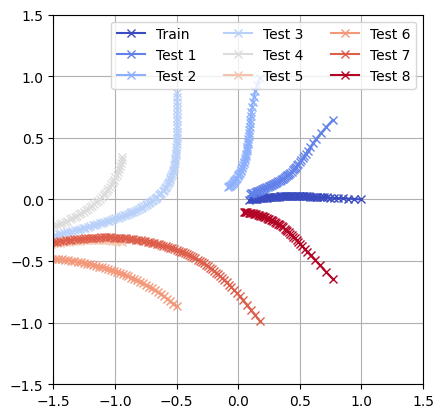

In [41]:
cmap = plt.get_cmap('coolwarm')
num_trajs = len(trajs_all_tasks)

for idx_traj, traj_task in enumerate(trajs_all_tasks):
    if idx_traj == 0:
        label="Train"
    else:
        label=f"Test {idx_traj}"
    color = cmap(idx_traj / max(1, num_trajs - 1))
    plt.plot(traj_task[:,0], traj_task[:,1], label=label, marker="x", color=color)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend(ncols=3)
plt.gca().set_aspect('equal')
plt.grid()

## Equivariant Policy

In [37]:
Lg = lambda theta : np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
Kg = lambda theta : np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]]) #Runs counter-clockwise! Not the same as Lg

def sample_traj_of_env_via_sym(task, base_policy, Kg, Lg):
    """Rolls out a base policy in a new task via equivariance."""
    Kg_inv = np.linalg.inv(Kg)
    Lg_inv = np.linalg.inv(Lg)

    trajectory = []
    rewards = []
    actions = []

    n_steps = 100
    obs_tilde = task.reset()
    trajectory.append(obs_tilde.copy())
    obs_base = Lg_inv @ obs_tilde

    for _ in range(n_steps):
        action_base, _ = base_policy.predict(obs_base, deterministic=True)
        action_tilde = Kg_inv @ action_base
        obs_tilde, reward, done, _ = task.step(action_tilde)

        obs_base = Lg_inv @ obs_tilde

        actions.append(action_tilde)
        trajectory.append(obs_tilde.copy())
        rewards.append(reward)

        if done:
            break  # end the rollout

    return np.array(trajectory)

all_trajs_equ = []

for test_task_idx, test_goal_position in enumerate(circle_points):
    test_env = CircleRotationEnv(s_init=test_goal_position)
    g_action = test_task_idx*2*np.pi/N_tasks
    Kg_test_task = Kg(g_action)
    Lg_test_task = Lg(g_action)

    traj_equ = sample_traj_of_env_via_sym(task=test_env, base_policy=model, Kg=Kg_test_task, Lg=Lg_test_task)
    all_trajs_equ.append(traj_equ)

In [32]:
TEST_TASK_IDX = 1
test_task_goal = circle_points[TEST_TASK_IDX]
test_env = CircleRotationEnv(s_init=test_task_goal)
g_action = TEST_TASK_IDX*2*np.pi/N_tasks

In [33]:
Kg_test_task = Kg(g_action)
Lg_test_task = Lg(g_action)

traj_task_1_equ = sample_traj_of_env_via_sym(task=test_env, base_policy=model, Kg=Kg_test_task, Lg=Lg_test_task)

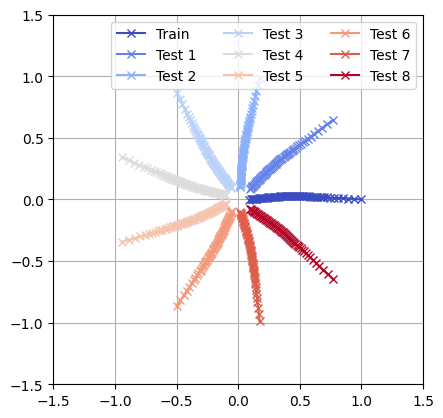

In [40]:
cmap = plt.get_cmap('coolwarm')
num_trajs = len(all_trajs_equ)

for idx_traj, traj_task_equ in enumerate(all_trajs_equ):
    if idx_traj == 0:
        label="Train"
    else:
        label=f"Test {idx_traj}"
    color = cmap(idx_traj / max(1, num_trajs - 1))
    plt.plot(traj_task_equ[:,0], traj_task_equ[:,1], label=label, marker="x", color=color)
    plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.legend(ncols=3)
plt.gca().set_aspect('equal')
plt.grid()

## Task Inference

- Given a trajectory in a new task sampled according to the base policy, we aim to find out what left-action generated this task.
- If they both start in the same state

In [ ]:
generator_lg = np.array([[0, -1], [1, 0]])
generator_kg = np.array([[0, 1], [-1, 0]])

idx_test_task = 1
traj_base = trajs_all_tasks[0]
traj_test = trajs_all_tasks[0]

In [42]:
trajs_all_tasks

[array([[ 1.00000000e+00,  0.00000000e+00],
        [ 9.44127638e-01,  4.10809368e-03],
        [ 8.94452341e-01,  6.99371845e-03],
        [ 8.50653093e-01,  9.19613242e-03],
        [ 8.12248543e-01,  1.11597106e-02],
        [ 7.78599240e-01,  1.30631104e-02],
        [ 7.49021053e-01,  1.48575306e-02],
        [ 7.23018564e-01,  1.65178180e-02],
        [ 7.00048916e-01,  1.79402381e-02],
        [ 6.79531127e-01,  1.92801356e-02],
        [ 6.61027938e-01,  2.04731226e-02],
        [ 6.43904842e-01,  2.14560255e-02],
        [ 6.27992943e-01,  2.22481862e-02],
        [ 6.13126129e-01,  2.28911862e-02],
        [ 5.99064641e-01,  2.34606937e-02],
        [ 5.85750200e-01,  2.39726007e-02],
        [ 5.72962560e-01,  2.44650319e-02],
        [ 5.60661100e-01,  2.49792188e-02],
        [ 5.48819520e-01,  2.55490839e-02],
        [ 5.37263997e-01,  2.61052325e-02],
        [ 5.25939114e-01,  2.66291201e-02],
        [ 5.14807671e-01,  2.71033198e-02],
        [ 5.03835037e-01,  2.750